# 01-01 : ktrain Multi-Label Classification

## References

- [Toxic Comments: Multi-Label Text Classification](https://github.com/amaiya/ktrain/blob/master/examples/text/toxic_comments-fasttext.ipynb)

In [1]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

In [2]:
import pandas as pd
import numpy as np
import ktrain
from ktrain import text
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report

In [3]:
data_path = '../../data'
input_path = f'{data_path}/input/labelled_tweets/csv_labels'
train_input_file = f'{input_path}/train.csv'
test_input_file = f'{input_path}/test.csv'
val_input_file = f'{input_path}/val.csv'

## 1. Load Data

In [4]:
df_train = pd.read_csv(train_input_file)
df_val = pd.read_csv(val_input_file)
df_test = pd.read_csv(test_input_file)

# show the data frame shapes
print(f'Train shape: {df_train.shape}')
print(f'Val shape: {df_val.shape}')
print(f'Test shape: {df_test.shape}')

Train shape: (6957, 3)
Val shape: (987, 3)
Test shape: (1977, 3)


In [5]:
df_train.head()

,ID,text,labels
0,1311981051720409089t,"@sandraburgess3 They have no idea , they cant ...",ineffective
1,1361403925845401601t,@stepheniscowboy Nvm I ’ ve had covid I ’ ve g...,unnecessary
2,1293488278361055233t,Coronavirus updates : Government partners with...,pharma
3,1305252218526990338t,@OANN U . K . Glaxo Smith Klein whistleblower ...,rushed
4,1376135683400687618t,"3 / horse "" AstraZeneca , not so much for the ...",ineffective pharma


## 2. Preprocessing

### 2.1. Labels to List

In [6]:
df_train['labels_list'] = df_train['labels'].str.split(' ')
df_test['labels_list'] = df_test['labels'].str.split(' ')
df_val['labels_list'] = df_val['labels'].str.split(' ')

In [7]:
df_train.head()

,ID,text,labels,labels_list
0,1311981051720409089t,"@sandraburgess3 They have no idea , they cant ...",ineffective,[ineffective]
1,1361403925845401601t,@stepheniscowboy Nvm I ’ ve had covid I ’ ve g...,unnecessary,[unnecessary]
2,1293488278361055233t,Coronavirus updates : Government partners with...,pharma,[pharma]
3,1305252218526990338t,@OANN U . K . Glaxo Smith Klein whistleblower ...,rushed,[rushed]
4,1376135683400687618t,"3 / horse "" AstraZeneca , not so much for the ...",ineffective pharma,"[ineffective, pharma]"


### 2.2. Multi-label Binarization

In [8]:
# get the list of label values
labels = pd.concat([df_train.labels_list, 
                    df_val.labels_list, 
                    df_test.labels_list])

# initialize MultiLabelBinarizer
labels_lookup = MultiLabelBinarizer()

# learn the vocabulary
labels_lookup = labels_lookup.fit(labels)

# show the vocabulary
vocab = labels_lookup.classes_
print(f'Vocabulary size: {len(vocab)}')
print(f'Vocabulary: {vocab}')


Vocabulary size: 12
Vocabulary: ['conspiracy' 'country' 'ineffective' 'ingredients' 'mandatory' 'none'
 'pharma' 'political' 'religious' 'rushed' 'side-effect' 'unnecessary']


In [9]:
# add the one-hot encoded labels as columns to the data frames
df_train = df_train.join(pd.DataFrame(labels_lookup.transform(df_train.labels_list), 
                                     columns=labels_lookup.classes_, 
                                     index=df_train.index))

df_val = df_val.join(pd.DataFrame(labels_lookup.transform(df_val.labels_list),
                                    columns=labels_lookup.classes_,
                                    index=df_val.index))

df_test = df_test.join(pd.DataFrame(labels_lookup.transform(df_test.labels_list),
                                    columns=labels_lookup.classes_,
                                    index=df_test.index))

In [10]:
df_test.head()

,ID,text,labels,labels_list,conspiracy,country,ineffective,ingredients,mandatory,none,pharma,political,religious,rushed,side-effect,unnecessary
0,1329097028845105155t,@nbc4i Please everyone research Pfizer ’ s his...,pharma,[pharma],0,0,0,0,0,0,1,0,0,0,0,0
1,1340017965828349952t,EVEN WITH A VACCINE IT IS STILL NOT ENOUGH . T...,conspiracy political,"[conspiracy, political]",1,0,0,0,0,0,0,1,0,0,0,0
2,1329126491649683459t,@ianbrown @DarrenPlymouth It ’ s the unknown l...,side-effect,[side-effect],0,0,0,0,0,0,0,0,0,0,1,0
3,1285666197003018240t,@FACT_Exeter @K3T3R @respect65 Back to my orig...,rushed,[rushed],0,0,0,0,0,0,0,0,0,1,0,0
4,1284814348679028737t,@DrJasonJohnson IMHO optimistic talk about a v...,ineffective,[ineffective],0,0,1,0,0,0,0,0,0,0,0,0


### 2.3. ktrain Text Preparation

In [11]:
(train, validate, preproc) = \
    text.texts_from_df(train_df=df_train,
                       text_column='text',
                       label_columns=list(vocab),
                       val_df=df_val,
                       maxlen=512,
                       preprocess_mode='bert',
                       ngram_range=1)

['conspiracy', 'country', 'ineffective', 'ingredients', 'mandatory', 'none', 'pharma', 'political', 'religious', 'rushed', 'side-effect', 'unnecessary']
   conspiracy  country  ineffective  ingredients  mandatory  none  pharma  \
0           0        0            1            0          0     0       0   
1           0        0            0            0          0     0       0   
2           0        0            0            0          0     0       1   
3           0        0            0            0          0     0       0   
4           0        0            1            0          0     0       1   

   political  religious  rushed  side-effect  unnecessary  
0          0          0       0            0            0  
1          0          0       0            0            1  
2          0          0       0            0            0  
3          0          0       1            0            0  
4          0          0       0            0            0  
['conspiracy', 'country'

Is Multi-Label? True
preprocessing test...
language: en


## 3. Training

### 3.1. Create Model

In [12]:
 # create the model
model = text.text_classifier(name='bert', 
                             train_data=train,
                             preproc=preproc)

Is Multi-Label? True
maxlen is 512


/home/johnny/swan/miniconda3/envs/caves-data/lib/python3.10/site-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


done.


### 3.2. Create Learner

In [13]:
 # create the learner
learner = ktrain.get_learner(
    model=model, 
    train_data=train,
    val_data=validate,
    batch_size=8)

simulating training for different learning rates... this may take a few moments...


/home/johnny/swan/miniconda3/envs/caves-data/lib/python3.10/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/1024
870/870 [==============================] - 247s 260ms/step - loss: 0.3675 - binary_accuracy: 0.8504
Epoch 2/1024
870/870 [==============================] - 148s 170ms/step - loss: 1.6796 - binary_accuracy: 0.8632


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


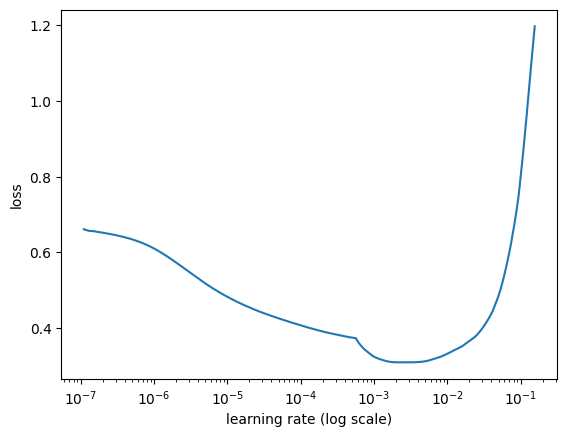

In [14]:
# find best learning rate
learner.lr_find()
learner.lr_plot()

### 3.3. Fit the model

In [15]:
history = learner.autofit(lr=1e-4)

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/1024
870/870 [==============================] - 255s 276ms/step - loss: 0.2139 - binary_accuracy: 0.9232 - val_loss: 0.1537 - val_binary_accuracy: 0.9443
Epoch 2/1024
870/870 [==============================] - 237s 272ms/step - loss: 0.1381 - binary_accuracy: 0.9490 - val_loss: 0.1444 - val_binary_accuracy: 0.9459
Epoch 3/1024
870/870 [==============================] - 236s 271ms/step - loss: 0.1019 - binary_accuracy: 0.9634 - val_loss: 0.1532 - val_binary_accuracy: 0.9450
Epoch 4/1024
870/870 [==============================] - ETA: 0s - loss: 0.0781 - binary_accuracy: 0.9729
Epoch 00004: Reducing Max LR on Plateau: new max lr will be 5e-05 (if not early_stopping).
870/870 [==============================] - 236s 271ms/step - loss: 0.0781 - binary_accuracy: 0.9729 - val_loss: 0.1718 - val_binary_a

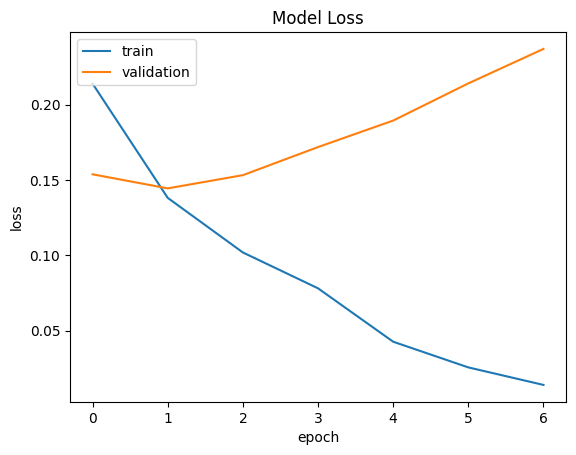

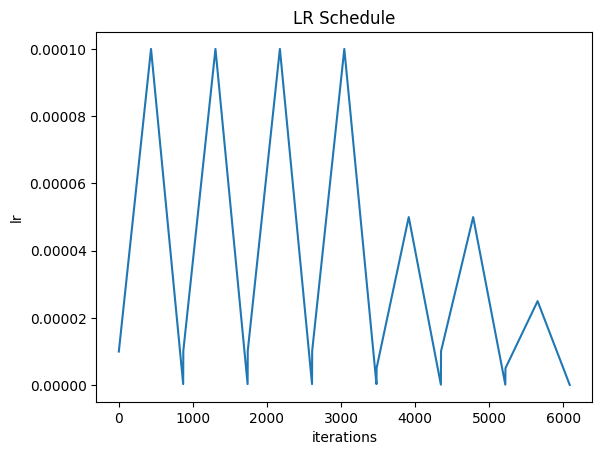

In [16]:
# plot the training history
learner.plot('loss')
learner.plot('lr')

In [17]:
# save the model
predictor = ktrain.get_predictor(learner.model, preproc)
predictor.save('../../models/01-01_bert_predictor')

/home/johnny/swan/miniconda3/envs/caves-data/lib/python3.10/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## 4. Evaluating the model

### 4.1. Classification Report

In [18]:
def show_classification_report(data:pd.DataFrame,
                               y_pred:np.ndarray,
                               threshold:float=0.5):
    # get the true labels
    y_true = data[vocab].values
    
    # Convert predictions to binary
    y_pred_bin = [[int(prob > threshold) for label, prob in pred] for pred in y_pred]
    
    # show the classification report
    print(classification_report(y_true, y_pred_bin, target_names=vocab))    

In [19]:
# show the test classification report
y_pred = predictor.predict(df_test.text.values.tolist())
show_classification_report(df_test, y_pred)

              precision    recall  f1-score   support

  conspiracy       0.63      0.33      0.43        97
     country       0.70      0.47      0.57        40
 ineffective       0.73      0.74      0.73       334
 ingredients       0.68      0.57      0.62        87
   mandatory       0.83      0.66      0.74       157
        none       0.68      0.33      0.44       126
      pharma       0.69      0.62      0.66       255
   political       0.71      0.36      0.48       125
   religious       0.61      0.85      0.71        13
      rushed       0.76      0.71      0.73       295
 side-effect       0.86      0.78      0.82       762
 unnecessary       0.72      0.42      0.53       145

   micro avg       0.77      0.65      0.70      2436
   macro avg       0.72      0.57      0.62      2436
weighted avg       0.76      0.65      0.69      2436
 samples avg       0.70      0.67      0.67      2436



/home/johnny/swan/miniconda3/envs/caves-data/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
